<a href="https://colab.research.google.com/github/prayas99/Image_Denoising_Matlab_Datasets/blob/main/Image_Denoising_Matlab_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import scipy
import sklearn
from sklearn.feature_extraction import image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

# Defining required functions

In [ ]:
def prob_post(y, x, method,alpha, gamma=1): 
    # If alpha is out of range, then exit the function 
    if alpha < 0 or alpha > 1:
        return
    h,w = y.shape
    # Likelihood of MRF
    likelihood = np.sum(np.square(np.absolute(y-x)))
    # Defining the 4 neighbours
    above = np.absolute(x-np.roll(x, [1,0], [0,1]))
    below = np.absolute(x-np.roll(x, [h-1,0], [0,1]))
    left = np.absolute(x-np.roll(x, [0,1], [0,1]))
    right = np.absolute(x-np.roll(x, [0,w-1], [0,1]))    
    # Defining the differnet MRF priors 
    if method=="quadratic":
        prior = np.sum(np.square(above) + np.square(below) + np.square(left) + np.square(right))
    # np.less_equal and np.greater takes care of inequalities
    elif method=="huber":
        prior_above = np.multiply(np.less_equal(above,gamma) , above**2/2) + np.multiply(np.greater(above,gamma) , (gamma*above - gamma**2/2)) 
        prior_below = np.multiply(np.less_equal(below,gamma) , below**2/2) + np.multiply(np.greater(below,gamma) , (gamma*below - gamma**2/2)) 
        prior_left = np.multiply(np.less_equal(left,gamma) , left**2/2) + np.multiply(np.greater(left,gamma) , (gamma*left - gamma**2/2)) 
        prior_right = np.multiply(np.less_equal(right,gamma) , right**2/2) + np.multiply(np.greater(right,gamma) , (gamma*right - gamma**2/2)) 
        prior = np.sum(prior_above + prior_below + prior_left + prior_right)
    # Discontinuity-adaptive function is named as log as it involves logarithmic term
    elif method=="log":
        prior_above = gamma*above - gamma**2*np.log(1+above/gamma)
        prior_below = gamma*below - gamma**2*np.log(1+below/gamma)
        prior_left = gamma*left - gamma**2*np.log(1+left/gamma)
        prior_right =gamma*right - gamma**2*np.log(1+right/gamma)     
        prior = np.sum(prior_above + prior_below + prior_left + prior_right)
    # Returning the weighted some of likelihood and prior weighted by alpha
    return (1-alpha)*likelihood + alpha*prior

def partial_derivatives(y,x,method, alpha, gamma=1):

    # If alpha is out of range, then exit the function 
    if alpha < 0 or alpha > 1:
        return
    h,w = y.shape
    # Likelihood of MRF
    likelihood = np.sum(np.square(np.absolute(y-x)))
    # Defining the 4 neighbours
    above = np.absolute(x-np.roll(x, [1,0], [0,1]))
    below = np.absolute(x-np.roll(x, [h-1,0], [0,1]))
    left = np.absolute(x-np.roll(x, [0,1], [0,1]))
    right = np.absolute(x-np.roll(x, [0,w-1], [0,1]))    

    # Defining the gradients of differnet MRF priors    
    
    if method=="quadratic":
        prior = 2*(above+below+left+right)
    elif method=="huber":
        prior_above = np.multiply(np.less_equal(np.absolute(above),gamma) , above) + np.multiply(np.greater(np.absolute(above),gamma) , (gamma*above/np.abs(above) ) )
        prior_below =  np.multiply(np.less_equal(np.absolute(below),gamma) , below) + np.multiply(np.greater(np.absolute(below),gamma) , (gamma*below/np.abs(below) ) )
        prior_left =  np.multiply(np.less_equal(np.absolute(left),gamma) , left) + np.multiply(np.greater(np.absolute(left),gamma) , (gamma*left/np.abs(left) ) )
        prior_right = np.multiply(np.less_equal(np.absolute(right),gamma) , right) + np.multiply(np.greater(np.absolute(right),gamma) , (gamma*right/np.abs(right) ) )
        prior = prior_above + prior_below + prior_left + prior_right
    elif method=="log":
        prior_above = np.multiply(gamma*above , np.reciprocal(gamma + np.absolute(above)))
        prior_below = np.multiply(gamma*below , np.reciprocal(gamma + np.absolute(below)))
        prior_left = np.multiply(gamma*left , np.reciprocal(gamma + np.absolute(left)))
        prior_right =np.multiply (gamma*right , np.reciprocal(gamma + np.absolute(right)) )    
        prior = prior_above + prior_below + prior_left + prior_right
        
    return (1-alpha)*likelihood + alpha*prior    

def denoising_formulation(imgNoisy, alpha, gamma, step, thresh, method):
    noisy_pic_array = np.copy(imgNoisy)
    noisy_pic_post = prob_post(imgNoisy, noisy_pic_array,method, alpha)
    prob_post_val = []
    prob_post_val.append(prob_post)    
    if method=="huber" or method=="log":
        # Running iterations 30 times
        for i in range(30):
            gradients_pic = partial_derivatives(imgNoisy,noisy_pic_array,method, alpha,gamma)
            # Taking gradient descent step
            new_noisy_pic = noisy_pic_array - step*gradients_pic
            new_prob_post = prob_post(imgNoisy, new_noisy_pic,method, alpha,gamma)   
        
            if new_prob_post < noisy_pic_post:
                # Dynamic step size
                step  = 1.1*step
                noisy_pic_array = new_noisy_pic
                noisy_pic_post = new_prob_post
        
            else:
                step = 0.5*step
            prob_post_val.append(noisy_pic_post)

    else:
        while step > thresh:    
            gradients_pic = partial_derivatives(imgNoisy,noisy_pic_array,method, alpha)
            new_noisy_pic = noisy_pic_array - step*gradients_pic
            new_prob_post = prob_post(imgNoisy, new_noisy_pic,method, alpha)   
        
            if new_prob_post < noisy_pic_post:
                step  = 1.1*step
                noisy_pic_array = new_noisy_pic
                noisy_pic_post = new_prob_post
        
            else:
                step = 0.5*step
            prob_post_val.append(noisy_pic_post)   
                      
    return prob_post_val, new_noisy_pic

def rrmse(y,x):
    return (np.linalg.norm(np.absolute(y)- np.absolute(x) ))/(np.linalg.norm(x))

# Phantom

# Enter Path of file

In [ ]:
path_to_phantom = 'path_to_file/assignmentImageDenoisingPhantom.mat'

In [ ]:
# !gdown --id 1XoPkniMB7PgCRtEFx2jQ6R9kgIdRLkrD

In [ ]:
S=scipy.io.loadmat(path_to_phantom);
print(S.keys())
imageNoisy = S['imageNoisy']
imageNoiseless = S['imageNoiseless'] 

dict_keys(['__header__', '__version__', '__globals__', 'imageNoiseless', 'imageNoisy'])


**Parameter Tuning for Quadratic Function as Prior**

Original error of noisy image : 0.2985791571243724
Obtained error with optimal alpha as=0.8 for quad prior : 0.27944568414285176
Obtained error with optimal alpha as=0.96 for quad prior : 0.285129502488644
Obtained error with optimal alpha as=0.6400000000000001 for quad prior : 0.281965970880443


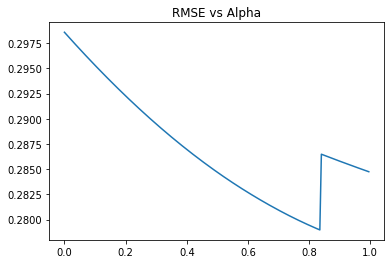

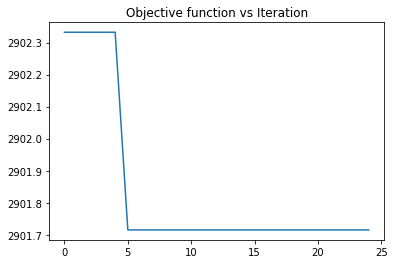

In [ ]:
# Parameter Tuning for quadratic prior
threshold = 1e-7
alpha_opt_list = []
alpha_opt_list.append(0)        
alpha = alpha_opt_list[0]
step = 1

rrmse_quad=[]
while alpha <= 1:  
    post, denoised_model_quad = denoising_formulation(imageNoisy, alpha, 1, step, threshold, "quadratic")
    rrmse_quad.append(rrmse(denoised_model_quad, imageNoiseless))
    alpha+=0.005
    alpha_opt_list.append(alpha)
    
alpha_opt_list = alpha_opt_list[:-1] 
plt.figure()   
plt.plot(alpha_opt_list, rrmse_quad)  
plt.title('RMSE vs Alpha') 
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_RMSE_Vs_Alpha.jpg', dpi=600)

# From RMSE vs Alpha we note that 0.125 seems as best value of alpha
alpha_opt = 0.8   
post, denoised_model_quad = denoising_formulation(imageNoisy, 0.8, 1, step, threshold, "quadratic")
post = post[1:]
post_alpha1, denoised_model_quad_alpha1 = denoising_formulation(imageNoisy, 1.2*alpha_opt, 1, step, threshold, "quadratic")
post_alpha2, denoised_model_quad_alpha2 = denoising_formulation(imageNoisy, 0.8*alpha_opt, 1, step, threshold, "quadratic")

rrmse_noisy = rrmse(imageNoisy, imageNoiseless)
rrmse_quad_denoised = rrmse(denoised_model_quad, imageNoiseless)
rrmse_quad_alpha1 = rrmse(denoised_model_quad_alpha1, imageNoiseless)
rrmse_quad_alpha2 = rrmse(denoised_model_quad_alpha2, imageNoiseless)

print('Original error of noisy image : %s' %(rrmse_noisy))
print('Obtained error with optimal alpha as=%s for quad prior : %s' %(alpha_opt, rrmse_quad_denoised))
print('Obtained error with optimal alpha as=%s for quad prior : %s' %(1.2*alpha_opt, rrmse_quad_alpha1))
print('Obtained error with optimal alpha as=%s for quad prior : %s' %(0.8*alpha_opt, rrmse_quad_alpha2))

#Objective Function vs Iteration

plt.figure() 
x_axis = np.arange(25) 
plt.plot(x_axis, post)
plt.title('Objective function vs Iteration')
##plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_ObjFunc_Vs_Iter.jpg', dpi=600)
plt.show()

**Parameter Tuning for Huber Function as Prior**

Obtained error with optimal alpha as=1 and gamma=0.00304 for huber prior : 0.23445293238321402
Obtained error with optimal alpha as=0.8 and gamma=0.00304 for huber prior : 0.276087024860775
Obtained error with optimal alpha as=1 and gamma=0.003648 for huber prior : 0.2353654641027315
Obtained error with optimal alpha as=1 and gamma=0.002432 for huber prior : 0.2352445658553362


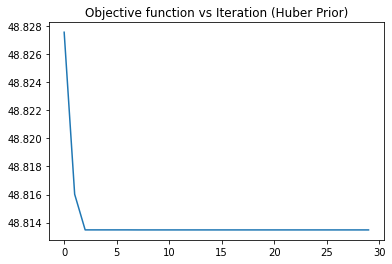

In [ ]:
# Parameter Tuning for huber prior

#threshold = 1e-6
#alpha_opt_list = []
#alpha_opt_list.append(0.995)        
#alpha = alpha_opt_list[0]
#step = 1
#gamma_opt = []
#
#rrmse_quad=[]
#while alpha <= 1:  
#    gamma = 0.003
#    gamma_list = []
#    gamma_list.append(gamma)
#    rrmse_quad_list = []
#    while gamma < 0.004:
#        post, denoised_model_quad = denoising_formulation(imageNoisy, alpha, gamma, step, threshold, "huber")
#        rrmse_quad_list.append(rrmse(denoised_model_quad, imageNoiseless))
#        gamma+=0.0001
#        gamma_list.append(gamma)
#    alpha+=0.0005
#    alpha_opt_list.append(alpha)
#    rrmse_quad.append(rrmse_quad_list)
#    gamma_opt.append(gamma_list)
# gamma_list = gamma_list[:-1] 
# plt.figure()   
# plt.plot(gamma_list, rrmse_quad)  
# plt.title('RMSE vs Gamma') 

# By observing the graph, we note best alpha = 1 and best gamma = 0.0041
alpha_opt = 1
gamma_opt = 0.00304
post, denoised_model_huber = denoising_formulation(imageNoisy, alpha_opt, gamma_opt, step, threshold, "huber")
post = post[1:]
post_alpha2, denoised_model_huber_alpha2 = denoising_formulation(imageNoisy, 0.8*alpha_opt, gamma_opt, step, threshold, "huber")
post_gamma1, denoised_model_huber_gamma1 = denoising_formulation(imageNoisy, alpha_opt, 1.2*gamma_opt, step, threshold, "huber")
post_gamma2, denoised_model_huber_gamma2 = denoising_formulation(imageNoisy, alpha_opt, 0.8*gamma_opt, step, threshold, "huber")

rrmse_huber_denoised = rrmse(denoised_model_huber, imageNoiseless)
rrmse_huber_alpha2 = rrmse(denoised_model_huber_alpha2, imageNoiseless)
rrmse_huber_gamma1 = rrmse(denoised_model_huber_gamma1, imageNoiseless)
rrmse_huber_gamma2 = rrmse(denoised_model_huber_gamma2, imageNoiseless)

print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(alpha_opt, gamma_opt,rrmse_huber_denoised))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(0.8*alpha_opt, gamma_opt,rrmse_huber_alpha2))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(alpha_opt, 1.2*gamma_opt,rrmse_huber_gamma1))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(alpha_opt, 0.8*gamma_opt,rrmse_huber_gamma2))

x_axis = np.arange(30)
plt.figure()
plt.plot(x_axis, post)
plt.title('Objective function vs Iteration (Huber Prior)')
##plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_ObjFunc_Vs_Iter_Huber.jpg', dpi=600)

**Parameter Tuning for Discontinuity-adaptive function as Prior**

Obtained error with optimal alpha as=1 and gamma=0.0024 for log prior : 0.23584170522169715
Obtained error with optimal alpha as=0.8 and gamma=0.0024 for log prior : 0.28201769695711354
Obtained error with optimal alpha as=1 and gamma=0.0028799999999999997 for log prior : 0.23445295040853198
Obtained error with optimal alpha as=1 and gamma=0.0019199999999999998 for log prior : 0.23636463515122297


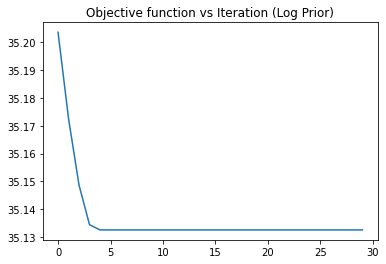

In [ ]:
#threshold = 1e-6
#alpha_opt_list = []
#alpha_opt_list.append(0.995)        
#alpha = alpha_opt_list[0]
#step = 1
#gamma_opt = []
#gamma_opt.append(0.001)        
#
#rrmse_quad=[]
#while alpha <= 1:  
#    gamma = 0.001
#    gamma_list = []
#    gamma_list.append(gamma)
#    rrmse_quad_list = []
#    while gamma < 0.002:
#        post, denoised_model_quad = denoising_formulation(imageNoisy, alpha, gamma, step, threshold, "log")
#        rrmse_quad_list.append(rrmse(denoised_model_quad, imageNoiseless))
#        gamma+=0.0001
#        gamma_list.append(gamma)
#    alpha+=0.0005
#    alpha_opt_list.append(alpha)
#    rrmse_quad.append(rrmse_quad_list)
#    gamma_opt.append(gamma_list)
# gamma_list = gamma_list[:-1] 
# plt.figure()   
# plt.plot(gamma_list, rrmse_quad)  
# plt.title('RMSE vs Gamma') 

# By observing the graph, we note best alpha = 1 and best gamma = 0.0017
alpha_opt = 1
gamma_opt = 0.0024
post, denoised_model_log = denoising_formulation(imageNoisy, alpha_opt, gamma_opt, step, threshold, "log")
post = post[1:]
post_alpha2, denoised_model_log_alpha2 = denoising_formulation(imageNoisy, 0.8*alpha_opt, gamma_opt, step, threshold, "log")
post_gamma1, denoised_model_log_gamma1 = denoising_formulation(imageNoisy, alpha_opt, 1.2*gamma_opt, step, threshold, "log")
post_gamma2, denoised_model_log_gamma2 = denoising_formulation(imageNoisy, alpha_opt, 0.8*gamma_opt, step, threshold, "log")

rrmse_log_denoised = rrmse(denoised_model_log, imageNoiseless)
rrmse_log_alpha2 = rrmse(denoised_model_log_alpha2, imageNoiseless)
rrmse_log_gamma1 = rrmse(denoised_model_log_gamma1, imageNoiseless)
rrmse_log_gamma2 = rrmse(denoised_model_log_gamma2, imageNoiseless)

print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(alpha_opt, gamma_opt,rrmse_log_denoised))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(0.8*alpha_opt, gamma_opt,rrmse_log_alpha2))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(alpha_opt, 1.2*gamma_opt,rrmse_log_gamma1))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(alpha_opt, 0.8*gamma_opt,rrmse_log_gamma2))

x_axis = np.arange(30)
plt.figure()
plt.plot(x_axis, post)
plt.title('Objective function vs Iteration (Log Prior)')
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_ObjFunc_Vs_Iter_Log2.jpg', dpi=600)
plt.show()

**Required Five Plots**

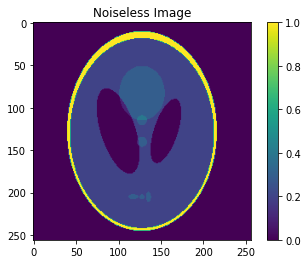

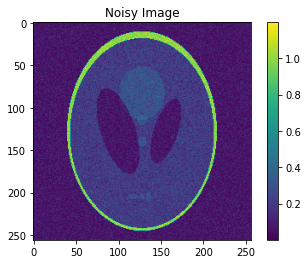

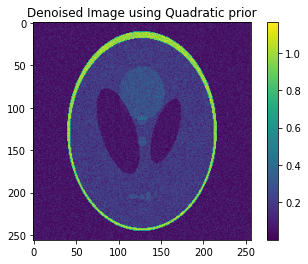

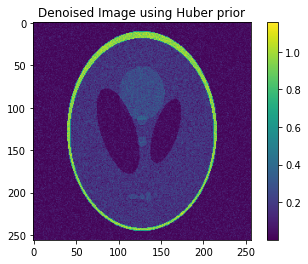

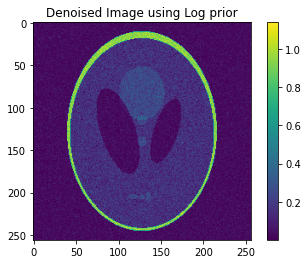

In [ ]:
plt.figure()
plt.imshow(imageNoiseless)
plt.title('Noiseless Image')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_Noiseless_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(imageNoisy))
plt.title('Noisy Image')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_Noisy_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(denoised_model_quad))
plt.title('Denoised Image using Quadratic prior')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_QuadPrior_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(denoised_model_huber))
plt.title('Denoised Image using Huber prior')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_HuberPrior_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(denoised_model_log))
plt.title('Denoised Image using Log prior')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q1_LogPrior_Image.jpg', dpi=600)
plt.show()

# Brain MRI

# Enter Path of file

In [ ]:
path_to_mri = '/path_to_file/brainMRIslice.mat'

In [ ]:
# !gdown --id 1rSt9Gb4_HSRWcesZbi8NpvnxRaq401e6

Downloading...
From: https://drive.google.com/uc?id=1rSt9Gb4_HSRWcesZbi8NpvnxRaq401e6
To: /content/brainMRIslice.mat
100% 612k/612k [00:00<00:00, 36.5MB/s]


In [ ]:
S=scipy.io.loadmat(path_to_mri);

imageNoisy = S['brainMRIsliceNoisy']
imageNoiseless = S['brainMRIsliceOrig']

**Parameter Tuning for Quadratic Function as Prior**

Original error of noisy image : 0.1424264796323439
Obtained error with optimal alpha as=0.05 and gamma=1 for quad prior : 0.14181429866572756
Obtained error with optimal alpha as=0.06 and gamma=1 for quad prior : 0.14169877651648033
Obtained error with optimal alpha as=0.04000000000000001 and gamma=1 for quad prior : 0.14193215558238


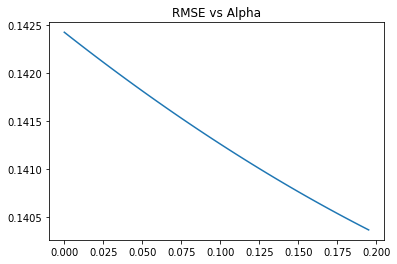

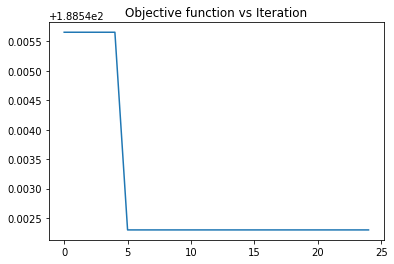

In [ ]:
threshold = 1e-7
alpha_opt_list = []
alpha_opt_list.append(0)        
alpha = alpha_opt_list[0]
step = 1

rrmse_quad=[]
while alpha <= 0.2:  
    post, denoised_model_quad = denoising_formulation(imageNoisy, alpha, 1, step, threshold, "quadratic")
    rrmse_quad.append(rrmse(denoised_model_quad, imageNoiseless))
    alpha+=0.005
    alpha_opt_list.append(alpha)
    
alpha_opt_list = alpha_opt_list[:-1] 
plt.figure()   
plt.plot(alpha_opt_list, rrmse_quad)  
plt.title('RMSE vs Alpha') 
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_RMSE_Vs_Alpha.jpg', dpi=600)
# From RMSE vs Alpha we note that 0.05 seems as best value of alpha
alpha_opt = 0.05  
post, denoised_model_quad = denoising_formulation(imageNoisy, 0.05, 1, step, threshold, "quadratic")
post = post[1:]
post_alpha1, denoised_model_quad_alpha1 = denoising_formulation(imageNoisy, 1.2*alpha_opt, 1, step, threshold, "quadratic")
post_alpha2, denoised_model_quad_alpha2 = denoising_formulation(imageNoisy, 0.8*alpha_opt, 1, step, threshold, "quadratic")

rrmse_noisy = rrmse(imageNoisy, imageNoiseless)
rrmse_quad_denoised = rrmse(denoised_model_quad, imageNoiseless)
rrmse_quad_alpha1 = rrmse(denoised_model_quad_alpha1, imageNoiseless)
rrmse_quad_alpha2 = rrmse(denoised_model_quad_alpha2, imageNoiseless)

print('Original error of noisy image : %s' %(rrmse_noisy))
print('Obtained error with optimal alpha as=%s and gamma=%s for quad prior : %s' %(alpha_opt, 1,rrmse_quad_denoised))
print('Obtained error with optimal alpha as=%s and gamma=%s for quad prior : %s' %(1.2*alpha_opt, 1,rrmse_quad_alpha1))
print('Obtained error with optimal alpha as=%s and gamma=%s for quad prior : %s' %(0.8*alpha_opt, 1,rrmse_quad_alpha2))

#Objective Function vs Iteration

plt.figure() 
x_axis = np.arange(25) 
plt.plot(x_axis, post)
plt.title('Objective function vs Iteration')
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_ObjFunc_Vs_Iter.jpg', dpi=600)


**Parameter Tuning for Huber Function as Prior**

Original error of noisy image : 0.1424264796323439
Obtained error with optimal alpha as=1 and gamma=0.0034 for huber prior : 0.14192804614628698
Obtained error with optimal alpha as=0.8 and gamma=0.0034 for huber prior : 0.13591445894959328
Obtained error with optimal alpha as=1 and gamma=0.004079999999999999 for huber prior : 0.14125774789942938
Obtained error with optimal alpha as=1 and gamma=0.00272 for huber prior : 0.13915917830673913


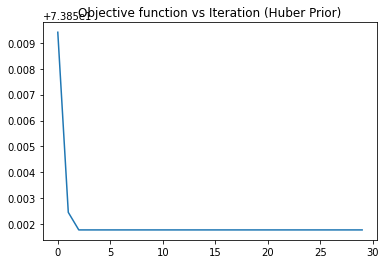

In [ ]:
#threshold = 1e-6
#alpha_opt_list = []
#alpha_opt_list.append(0.995)        
#alpha = alpha_opt_list[0]
#step = 1
#gamma_opt = []
#
#rrmse_quad=[]
#while alpha <= 1:  
#    gamma = 0.003
#    gamma_list = []
#    gamma_list.append(gamma)
#    rrmse_quad_list = []
#    while gamma < 0.004:
#        post, denoised_model_quad = denoising_formulation(imageNoisy, alpha, gamma, step, threshold, "huber")
#        rrmse_quad_list.append(rrmse(denoised_model_quad, imageNoiseless))
#        gamma+=0.0001
#        gamma_list.append(gamma)
#    alpha+=0.0005
#    alpha_opt_list.append(alpha)
#    rrmse_quad.append(rrmse_quad_list)
#    gamma_opt.append(gamma_list)
    
#%%    
#optimum values for huber prior
alpha_opt = 1
gamma_opt = 0.0034
post, denoised_model_huber = denoising_formulation(imageNoisy, alpha_opt, gamma_opt, step, threshold, "huber")
post = post[1:]
post_alpha2, denoised_model_huber_alpha2 = denoising_formulation(imageNoisy, 0.8*alpha_opt, gamma_opt, step, threshold, "huber")
post_gamma1, denoised_model_huber_gamma1 = denoising_formulation(imageNoisy, alpha_opt, 1.2*gamma_opt, step, threshold, "huber")
post_gamma2, denoised_model_huber_gamma2 = denoising_formulation(imageNoisy, alpha_opt, 0.8*gamma_opt, step, threshold, "huber")

rrmse_noisy = rrmse(imageNoisy, imageNoiseless)
rrmse_huber_denoised = rrmse(denoised_model_huber, imageNoiseless)
rrmse_huber_alpha2 = rrmse(denoised_model_huber_alpha2, imageNoiseless)
rrmse_huber_gamma1 = rrmse(denoised_model_huber_gamma1, imageNoiseless)
rrmse_huber_gamma2 = rrmse(denoised_model_huber_gamma2, imageNoiseless)

print('Original error of noisy image : %s' %(rrmse_noisy))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(alpha_opt, gamma_opt,rrmse_huber_denoised))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(0.8*alpha_opt, gamma_opt,rrmse_huber_alpha2))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(alpha_opt, 1.2*gamma_opt,rrmse_huber_gamma1))
print('Obtained error with optimal alpha as=%s and gamma=%s for huber prior : %s' %(alpha_opt, 0.8*gamma_opt,rrmse_huber_gamma2))

x_axis = np.arange(30)
plt.figure()
plt.plot(x_axis, post)
plt.title('Objective function vs Iteration (Huber Prior)')
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_ObjFunc_Vs_Iter_Huber.jpg', dpi=600)

**Parameter Tuning for Discontinuity-adaptive function as Prior**

Original error of noisy image : 0.1424264796323439
Obtained error with optimal alpha as=1 and gamma=0.0014 for log prior : 0.15749858785739265
Obtained error with optimal alpha as=0.8 and gamma=0.0014 for log prior : 0.13938562146107944
Obtained error with optimal alpha as=1 and gamma=0.0016799999999999999 for log prior : 0.15669801105995484
Obtained error with optimal alpha as=1 and gamma=0.0011200000000000001 for log prior : 0.16628557757856


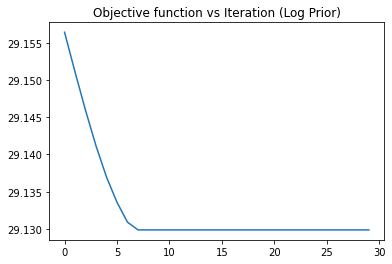

In [ ]:
#threshold = 1e-6
#alpha_opt_list = []
#alpha_opt_list.append(0.995)        
#alpha = alpha_opt_list[0]
#step = 1
#gamma_opt = []
#gamma_opt.append(0.001)        
#
#rrmse_quad=[]
#while alpha <= 1:  
#    gamma = 0.001
#    gamma_list = []
#    gamma_list.append(gamma)
#    rrmse_quad_list = []
#    while gamma < 0.002:
#        post, denoised_model_quad = denoising_formulation(imageNoisy, alpha, gamma, step, threshold, "log")
#        rrmse_quad_list.append(rrmse(denoised_model_quad, imageNoiseless))
#        gamma+=0.0001
#        gamma_list.append(gamma)
#    alpha+=0.0005
#    alpha_opt_list.append(alpha)
#    rrmse_quad.append(rrmse_quad_list)
#    gamma_opt.append(gamma_list)
    
#%%    
#optimum values for log prior
alpha_opt = 1
gamma_opt = 0.0014
post, denoised_model_log = denoising_formulation(imageNoisy, alpha_opt, gamma_opt, step, threshold, "log")
post = post[1:]
post_alpha2, denoised_model_log_alpha2 = denoising_formulation(imageNoisy, 0.8*alpha_opt, gamma_opt, step, threshold, "log")
post_gamma1, denoised_model_log_gamma1 = denoising_formulation(imageNoisy, alpha_opt, 1.2*gamma_opt, step, threshold, "log")
post_gamma2, denoised_model_log_gamma2 = denoising_formulation(imageNoisy, alpha_opt, 0.8*gamma_opt, step, threshold, "log")

rrmse_noisy = rrmse(imageNoisy, imageNoiseless)
rrmse_log_denoised = rrmse(denoised_model_log, imageNoiseless)
rrmse_log_alpha2 = rrmse(denoised_model_log_alpha2, imageNoiseless)
rrmse_log_gamma1 = rrmse(denoised_model_log_gamma1, imageNoiseless)
rrmse_log_gamma2 = rrmse(denoised_model_log_gamma2, imageNoiseless)

print('Original error of noisy image : %s' %(rrmse_noisy))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(alpha_opt, gamma_opt,rrmse_log_denoised))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(0.8*alpha_opt, gamma_opt,rrmse_log_alpha2))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(alpha_opt, 1.2*gamma_opt,rrmse_log_gamma1))
print('Obtained error with optimal alpha as=%s and gamma=%s for log prior : %s' %(alpha_opt, 0.8*gamma_opt,rrmse_log_gamma2))

x_axis = np.arange(30)
plt.figure()
plt.plot(x_axis, post)
plt.title('Objective function vs Iteration (Log Prior)')
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_ObjFunc_Vs_Iter_Log.jpg', dpi=600)


**Required Five Plots**

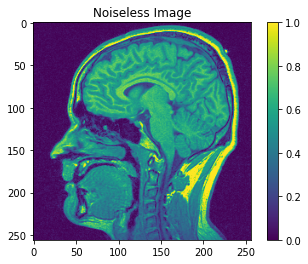

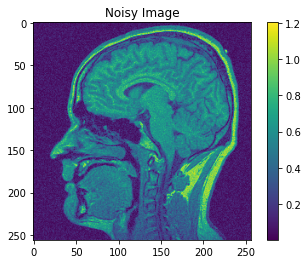

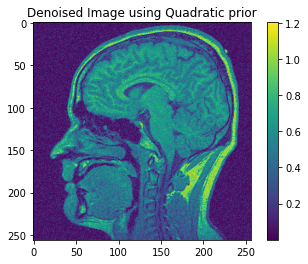

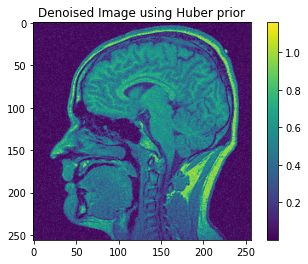

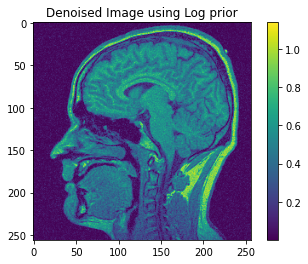

In [ ]:
plt.figure()
plt.imshow(imageNoiseless)
plt.title('Noiseless Image')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_Noiseless_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(imageNoisy))
plt.title('Noisy Image')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_Noisy_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(denoised_model_quad))
plt.title('Denoised Image using Quadratic prior')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_QuadPrior_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(denoised_model_huber))
plt.title('Denoised Image using Huber prior')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_HuberPrior_Image.jpg', dpi=600)

plt.figure()
plt.imshow(np.absolute(denoised_model_log))
plt.title('Denoised Image using Log prior')
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/IITB Sem6/Sem6_Material/Study material/CS 736/assignmentImageDenoising/data/Q2_LogPrior_Image.jpg', dpi=600)
plt.show()